In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from graspy.plot import heatmap
from graspy.utils import symmetrize, is_symmetric
from graspy.simulations import sbm

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc import MGC

from simulations import sbm_corr, ER_corr
from utils import triu_no_diag, to_distance_mtx, identity, sbm_params, dcorr_power_two_sided, pearson_power_two_sided, \
block_permute, sort_graph

In [111]:
def rho_gaussian_sbm(rho, k, AL, BL, n, var_x=1, var_y=1):
    if sum(k) != n:
        raise ValueError('the total number of vertices in each community \
        should equal n')
    sigma = np.array([[var_x, rho], [rho, var_y]])
    AL = symmetrize(AL)
    BL = symmetrize(BL)
    A = np.zeros((n, n))
    B = np.zeros((n, n))
    block_indices = np.insert(np.cumsum(k), 0, 0)
    
    for i in range(AL.shape[0]):
        for j in range(AL.shape[1]):
            mu_x = AL[i, j]
            mu_y = BL[i, j]
            sample = np.random.multivariate_normal([mu_x, mu_y], sigma, 
                    size=(block_indices[i+1]-block_indices[i], block_indices[j+1]-block_indices[j]))
            A[block_indices[i]:block_indices[i+1],
                   block_indices[j]:block_indices[j+1]] = sample[:, :, 0]
            B[block_indices[i]:block_indices[i+1],
                   block_indices[j]:block_indices[j+1]] = sample[:, :, 1]
    A = symmetrize(A)
    B = symmetrize(B)
    return A, B

In [112]:
AL = np.array([[0]])
BL = np.array([[0]])
A, B = rho_gaussian_sbm(rho=0.1, k=np.array([100]), AL=AL, BL=BL, n=100)

In [113]:
ER_corr(A, B)

0.11526329476867839

In [114]:
is_symmetric(A)

True

In [119]:
AL = np.array([[2, 1], [1, 2]])
BL = np.array([[4, 2], [2, 4]])
A, B = rho_gaussian_sbm(rho=0.8, k=np.array([50, 50]), AL=AL, BL=BL, n=100)

In [120]:
sbm_corr(A, B, k=2)

0.7921941090258029

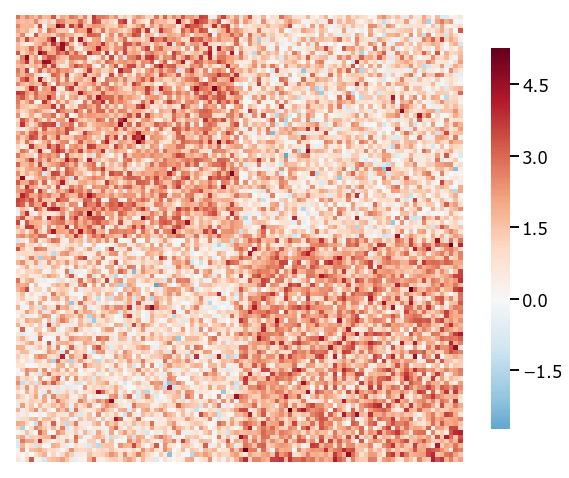

In [121]:
heatmap(A)

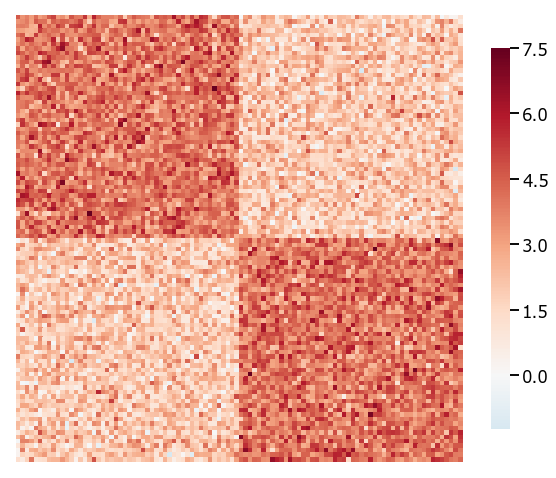

In [122]:
heatmap(B)

In [125]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1, -0.1])
P1 = np.array([[0]])
P2 = np.array([[0]])
nmc = 500
test_names = ['pearson', 'dcorr']
power_er = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            block_assignments = np.repeat(np.arange(k), n//k)
            block_sizes = np.array([n])
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = pearson_power_two_sided(test, rho_gaussian_sbm, 
                                                     given_blocks=True, blocks=block_assignments,
                                           rho=rho, AL=P1, BL=P2, k=block_sizes, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = dcorr_power_two_sided(test, rho_gaussian_sbm,
                                                given_blocks=True, blocks=block_assignments,
                                           rho=rho, AL=P1, BL=P2, k=block_sizes, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = dcorr_power_two_sided(test, rho_gaussian_sbm,
                                                given_blocks=True, blocks=block_assignments,
                                           rho=rho, AL=P1, BL=P2, k=block_sizes, n=n, mc=nmc)
            power_er[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100
finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100
finish pearson for rho=-0.1, n=10
finish pearson for rho=-0.1, n=20
finish pearson for rho=-0.1, n=30
finish pearson for rho=-0.1, n=40
finish pearson for rho=-0.1, n=50
finish pearson for rho=-0.1, n=60
finish pearson for rho=-0.1, n=70
finish pearson for rho=-0.1, n=80
finish pearson for rho=-0.1, n=90
finish pearson for rho=-0.1, n=1

In [126]:
power_er

{'pearson': array([[0.036, 0.066, 0.062, 0.048, 0.052, 0.046, 0.046, 0.062, 0.066,
         0.066],
        [0.068, 0.236, 0.542, 0.882, 0.964, 0.982, 1.   , 1.   , 1.   ,
         1.   ],
        [0.1  , 0.262, 0.59 , 0.808, 0.952, 0.976, 0.998, 1.   , 1.   ,
         1.   ]]),
 'dcorr': array([[0.018, 0.056, 0.048, 0.04 , 0.034, 0.034, 0.06 , 0.05 , 0.042,
         0.044],
        [0.122, 0.328, 0.506, 0.8  , 0.958, 0.986, 1.   , 1.   , 1.   ,
         1.   ],
        [0.098, 0.274, 0.592, 0.788, 0.938, 1.   , 0.998, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}

In [2]:
def process_parallel_output(graph_type):
    n_arr = np.linspace(10, 100, 10, dtype=int)
    rho_arr = np.array([0, 0.1, -0.1])
    test_names = ['pearson', 'dcorr', 'mgc']
    power = {
        'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
        'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
        'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
    }
    with open('../../results/rho_gaussain_power_parallel_{}.pkl'.format(graph_type), 'rb') as f:
        results = pickle.load(f)

    count = 0
    for name in test_names:
        for j, rho in enumerate(rho_arr):
            for k, n in enumerate(n_arr):
                power[name][j, k] = results[count][3]
                count += 1
            if count == n_arr.shape[0] * rho_arr.shape[0] - 1:
                count = 0
    with open('../../results/rho_gaussian_{}_power.pkl'.format(graph_type), 'wb') as f:
        pickle.dump(power, f)

In [11]:
graph_type = 'sbm_marg'
with open('../../results/rho_gaussian_{}_power.pkl'.format(graph_type), 'rb') as f:
    results = pickle.load(f)
results

{'pearson': array([[0.046, 0.042, 0.032, 0.048, 0.05 , 0.076, 0.064, 0.054, 0.036,
         0.058],
        [0.08 , 0.16 , 0.318, 0.59 , 0.748, 0.86 , 0.96 , 0.994, 1.   ,
         1.   ],
        [0.076, 0.13 , 0.318, 0.552, 0.716, 0.844, 0.96 , 0.98 , 0.998,
         0.998]]),
 'dcorr': array([[0.072, 0.04 , 0.048, 0.062, 0.044, 0.044, 0.048, 0.062, 0.042,
         0.04 ],
        [0.042, 0.172, 0.36 , 0.524, 0.722, 0.82 , 0.964, 0.996, 0.998,
         1.   ],
        [0.046, 0.16 , 0.322, 0.534, 0.704, 0.87 , 0.956, 0.99 , 0.998,
         1.   ]]),
 'mgc': array([[0.044, 0.068, 0.066, 0.086, 0.048, 0.074, 0.04 , 0.064, 0.062,
         0.034],
        [0.054, 0.134, 0.27 , 0.474, 0.724, 0.856, 0.962, 0.98 , 0.998,
         1.   ],
        [0.068, 0.138, 0.264, 0.55 , 0.724, 0.904, 0.954, 0.988, 0.986,
         1.   ]])}